In [1]:
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

from models import *
from datasets import *
from utils import *

import torch.nn as nn
import torch.nn.functional as F
import torch

from dataset.time_dataset import TsModifiedDataset
from pathlib import Path

import matplotlib.pyplot as plt

from dtw import dtw

In [2]:
# Dataset loader
datapath = Path('data')
dataset = TsModifiedDataset(datapath/'CaseI-Attacks without any change.csv', noise_type='none')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                        shuffle=True, num_workers=4)
print("The size of the dataset is: ", dataset.data_normal.size(), dataset.data_attacked.size())

The size of the dataset is:  torch.Size([33, 15, 1973]) torch.Size([33, 15, 1973])


In [3]:
normal_seq_len = dataset.data_normal.size(1)
normal_feature_len = dataset.data_normal.size(2)
attacked_seq_len = dataset.data_attacked.size(1)
attacked_feature_len = dataset.data_attacked.size(2)

In [4]:
G_AB = LSTMFullGenerator(normal_seq_len, normal_feature_len)
G_BA = LSTMFullGenerator(attacked_seq_len, attacked_feature_len)
D_A = LSTMFullDiscriminator(normal_feature_len)
D_B = LSTMFullDiscriminator(normal_feature_len)

In [5]:
G_AB.load_state_dict(torch.load("saved_models/cyber_gaussian/G_AB_190.pth"))
G_BA.load_state_dict(torch.load("saved_models/cyber_gaussian/G_BA_190.pth"))
D_A.load_state_dict(torch.load("saved_models/cyber_gaussian/D_A_190.pth"))
D_B.load_state_dict(torch.load("saved_models/cyber_gaussian/D_B_190.pth"))

<All keys matched successfully>

In [6]:
G_AB.eval()
G_BA.eval()
D_A.eval()
D_B.eval()

LSTMFullDiscriminator(
  (lstm): LSTM(1973, 256, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=256, out_features=1973, bias=True)
    (1): Sigmoid()
  )
)

In [22]:
threshold = 2.50

In [8]:
dataset_test = TsModifiedDataset(datapath/'CaseII.csv', noise_type='none')
# dataset_test = TsFinalDataset(datapath/'CaseI-Attacks without any change.csv', noise_type='none')
dataset_test.data_normal.size()

torch.Size([33, 15, 1973])

In [9]:
with torch.no_grad():
    output = G_AB(dataset_test.data_normal)
    output_back = G_BA(output)
print(f"Output size: {output.size()} \t Output Back size: {output_back.size()}")

Output size: torch.Size([33, 15, 1973]) 	 Output Back size: torch.Size([33, 15, 1973])


In [10]:
os.makedirs('cyber_result/gaussian/forward', exist_ok=True)
forward_res_list = []
for i in range(output.size(0)):
    plt.plot(output[i, 0, :].numpy())
    plt.plot(output_back[i, 0, :].numpy())
    plt.plot(dataset_test.data_normal[i, 0, :].numpy())
    plt.legend(['Generated', 'Generated Back', 'Original'])
    plt.savefig(f'cyber_result/gaussian/forward/output_{i}.png')
    plt.close()

    dist1, cost, acc, path = dtw(output[i,0,:].reshape(-1, 1), dataset_test.data_normal[i,0,:].reshape(-1, 1), dist=lambda x, y: np.linalg.norm(x - y, ord=1))
    dist2, cost, acc, path = dtw(output_back[i,0,:].reshape(-1, 1), output[i,0,:].reshape(-1, 1), dist=lambda x, y: np.linalg.norm(x - y, ord=1))
    dist3, cost, acc, path = dtw(output_back[i,0,:].reshape(-1, 1), dataset_test.data_normal[i,0,:].reshape(-1, 1), dist=lambda x, y: np.linalg.norm(x - y, ord=1))
    res = (dist2+dist3)/dist1
    print("+" if res < threshold else "-", res)
    forward_res_list.append(res)

- 2.3454223389245947
+ 1.7288918169192529
+ 1.8861529287945458
- 2.177516903912769
- 2.0125271637596605
+ 1.6948415587837637
+ 1.6948415587837637
+ 1.9318237999137742
- 2.014806249048275
- 2.035170764800037
- 2.226267615803295
- 2.293645212121009
- 2.3293077012505523
+ 0.830416543999204
+ 1.5503166588456454
+ 1.7940669048850537
+ 1.275086852207931
+ 1.3096813751722605
+ 1.9035975832868837
+ 1.6391821166238152
+ 1.4855288355117071
+ 1.6010039722422078
+ 1.4312607368599524
+ 1.4260497650618706
+ 1.8198541431893138
+ 1.9160596112634956
- 2.1634509908875628
+ 1.4855288355117071
+ 1.7264738408708709
+ 1.4518413525298763
- 2.192565949821701
- 2.715152090053944
+ 1.6511379554128258


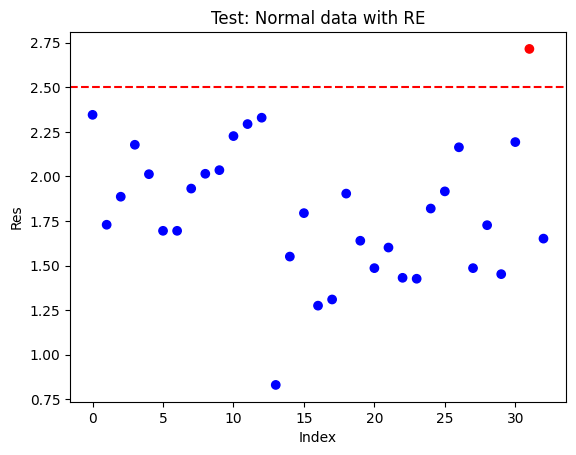

In [23]:
plt.figure()
# Assuming res_list and threshold are defined as in your code
colors = ['red' if res > threshold else 'blue' for res in forward_res_list]
# Scatter plot with individual colors for each point
plt.scatter(range(len(forward_res_list)), forward_res_list, color=colors)
plt.axhline(y=threshold, color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Res')
plt.title('Test: Normal data with RE')
plt.show()

---

In [12]:
dataset_test.data_attacked.size()

torch.Size([33, 15, 1973])

In [16]:
data_attacked_test = dataset_test.data_attacked
data_attacked_test.size()

torch.Size([33, 15, 1973])

In [17]:
with torch.no_grad():
    output = G_AB(data_attacked_test)
    output_back = G_BA(output)
print(f"Output size: {output.size()} \t Output Back size: {output_back.size()}")

Output size: torch.Size([33, 15, 1973]) 	 Output Back size: torch.Size([33, 15, 1973])


In [18]:
os.makedirs('cyber_result/gaussian/detection', exist_ok=True)
detection_res_list = []
for i in range(output.size(0)):
    plt.plot(output[i, 0, :].numpy())
    plt.plot(output_back[i, 0, :].numpy())
    plt.plot(data_attacked_test[i, 0, :].numpy())
    plt.legend(['Generated', 'Generated Back', 'Original'])
    plt.savefig(f'cyber_result/gaussian/detection/output_{i}.png')
    plt.close()

    dist1, cost, acc, path = dtw(output[i,0,:].reshape(-1, 1), data_attacked_test[i, 0, :].reshape(-1, 1), dist=lambda x, y: np.linalg.norm(x - y, ord=1))
    dist2, cost, acc, path = dtw(output_back[i,0,:].reshape(-1, 1), output[i,0,:].reshape(-1, 1), dist=lambda x, y: np.linalg.norm(x - y, ord=1))
    dist3, cost, acc, path = dtw(output_back[i,0,:].reshape(-1, 1), data_attacked_test[i, 0, :].reshape(-1, 1), dist=lambda x, y: np.linalg.norm(x - y, ord=1)) 
    res = (dist2+dist3)/dist1   
    print("+" if res < threshold else "-", res)
    detection_res_list.append(res)

+ 1.6121818108503885
+ 1.5639171745189797
+ 1.5683800401121495
+ 1.6097685302455558
+ 1.566817273897895
+ 1.5571847049790128
+ 1.5571847049790128
+ 1.5512696853363654
+ 1.551961493453116
+ 1.558288052161469
+ 1.5603192615271326
+ 1.5588275073326179
+ 1.5482553677490827
+ 0.7371501948676473
+ 1.4276481271705792
+ 1.946140353628805
- 2.021632285907531
+ 1.5091655589769517
+ 1.5978837884783434
+ 1.6469347596052375
+ 1.4448209811245571
+ 1.8218880953770935
+ 1.4310635588865637
+ 1.5393024050279456
+ 1.8361282914806918
+ 1.500804449622876
+ 1.6469347596052375
+ 1.4448209811245571
+ 1.6296692778425996
+ 1.724510361622205
+ 1.5800445285611275
+ 1.6795961233006786
+ 1.8452473403012397


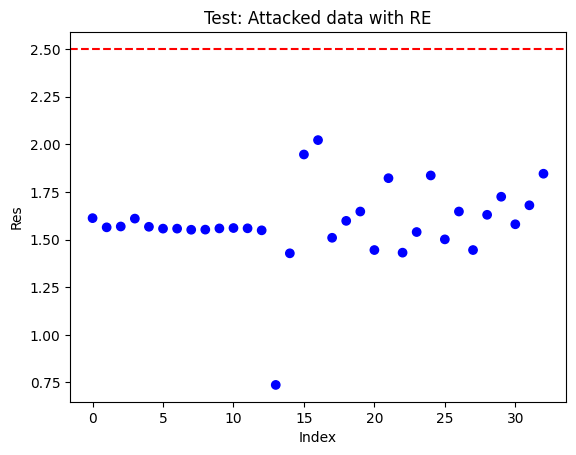

In [24]:
plt.figure()
# Assuming res_list and threshold are defined as in your code
colors = ['red' if res > threshold else 'blue' for res in detection_res_list]
# Scatter plot with individual colors for each point
plt.scatter(range(len(detection_res_list)), detection_res_list, color=colors)
plt.axhline(y=threshold, color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Res')
plt.title('Test: Attacked data with RE')
plt.show()

In [20]:
sorted(forward_res_list, reverse=True)

[2.715152090053944,
 2.3454223389245947,
 2.3293077012505523,
 2.293645212121009,
 2.226267615803295,
 2.192565949821701,
 2.177516903912769,
 2.1634509908875628,
 2.035170764800037,
 2.014806249048275,
 2.0125271637596605,
 1.9318237999137742,
 1.9160596112634956,
 1.9035975832868837,
 1.8861529287945458,
 1.8198541431893138,
 1.7940669048850537,
 1.7288918169192529,
 1.7264738408708709,
 1.6948415587837637,
 1.6948415587837637,
 1.6511379554128258,
 1.6391821166238152,
 1.6010039722422078,
 1.5503166588456454,
 1.4855288355117071,
 1.4855288355117071,
 1.4518413525298763,
 1.4312607368599524,
 1.4260497650618706,
 1.3096813751722605,
 1.275086852207931,
 0.830416543999204]

In [21]:
sorted(detection_res_list, reverse=True)

[2.021632285907531,
 1.946140353628805,
 1.8452473403012397,
 1.8361282914806918,
 1.8218880953770935,
 1.724510361622205,
 1.6795961233006786,
 1.6469347596052375,
 1.6469347596052375,
 1.6296692778425996,
 1.6121818108503885,
 1.6097685302455558,
 1.5978837884783434,
 1.5800445285611275,
 1.5683800401121495,
 1.566817273897895,
 1.5639171745189797,
 1.5603192615271326,
 1.5588275073326179,
 1.558288052161469,
 1.5571847049790128,
 1.5571847049790128,
 1.551961493453116,
 1.5512696853363654,
 1.5482553677490827,
 1.5393024050279456,
 1.5091655589769517,
 1.500804449622876,
 1.4448209811245571,
 1.4448209811245571,
 1.4310635588865637,
 1.4276481271705792,
 0.7371501948676473]